In [1]:
from snowpack_functions import mesh_gridify,make_map
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
## do all basins in one. 
## one figure: fire risk in all five basins 
## each figure: 1970-1999, 2010-2039, 2040-2069,2070-2099 (1 x 4) 
'''
basins = ['cascades','california','northernrockies','southernrockies','whites']
scenarios = ['historical','rcp45','rcp45,'rcp45','historical','rcp85','rcp85','rcp85']
chunks = ['1970-1999','2010-2039','2040-2069','2070-2099','1970-1999',2010-2039','2040-2069','2070-2099']
'''
chunk = "1970-1999"
scenario = "historical"
basin = "california"
### load data 
direc = '/raid9/gergel/agg_snowpack/%s/' %scenario
filename = "moistdef_%s_%s.npz" %(chunk,basin)
data = np.load(os.path.join(direc,filename))
lats = data['lats'] # (#lats,)
lons = data['lons'] # (#lats,)
pet = data['pet'][:,:,0]
#pet = pet[:,0,:,0] # (#lats,)
aet = data['aet'][:,0,:,0] # (#lats,)
coms = data['coms'] ## centers of mass (#lats,30)


In [13]:
def early_vs_late_moist_deficit(pet,aet,coms):
    perc_diffs = list()
    for gridcell in np.arange(len(pet)):
        ex_pet = pet[gridcell,:]
        ex_aet = aet[gridcell,:]
        ## subtract aet from pet to get cumulative moisture difference 
        pet_minus_aet = ex_pet - ex_aet 
        ex_coms = coms[gridcell,:]
        ## calculate statistics for centers of mass for this grid cell 
        mean_com = np.mean(ex_coms)
        std_com = np.std(ex_coms)
        late_ind = np.where(ex_coms >= mean_com + 2*std_com)
        early_ind = np.where(ex_coms <= mean_com - 2*std_com)
        #################################if no +2 sigma COMs, take the maximum COM of the time series
        if len(late_ind[0]) == 0: 
            late_ind = np.argmax(ex_coms)
            late_diff = pet_minus_aet[late_ind]
        ################################# if more than 1 +2 sigma COMs, take the smaller one
        elif (len(late_ind[0]) > 1):
            late_diff = np.min(pet_minus_aet[late_ind])
        ################################# otherwise, take the one index
        else: 
            late_diff = pet_minus_aet[late_ind]

        #################################if no +2 sigma COMs, take the minimum COM of the time series
        if len(early_ind[0]) == 0:
            early_ind = np.argmin(ex_coms)
            early_diff = pet_minus_aet[early_ind]
        ################################# if more than 1 -2 sigma COMs, take the larger one, otherwise, take the index of the one
        elif (len(early_ind[0]) > 1):
            early_diff = np.max(pet_minus_aet[early_ind])
        ################################# otherwise, take the one index
        else: 
            early_diff = pet_minus_aet[early_ind]
        ## percent difference between early and late snowmelt years
        # perc_diff = (early_diff - late_diff)/early_diff
        perc_diff = (early_diff - late_diff)/((early_diff + late_diff)/2)
        # perc_diffs.append(perc_diff[0])
        perc_diffs.append(perc_diff)
    defs = np.asarray(perc_diffs)
    return(defs.reshape(len(defs),))

saving figure to /raid9/gergel/agg_snowpack/fire_risk/plots/fire_risk


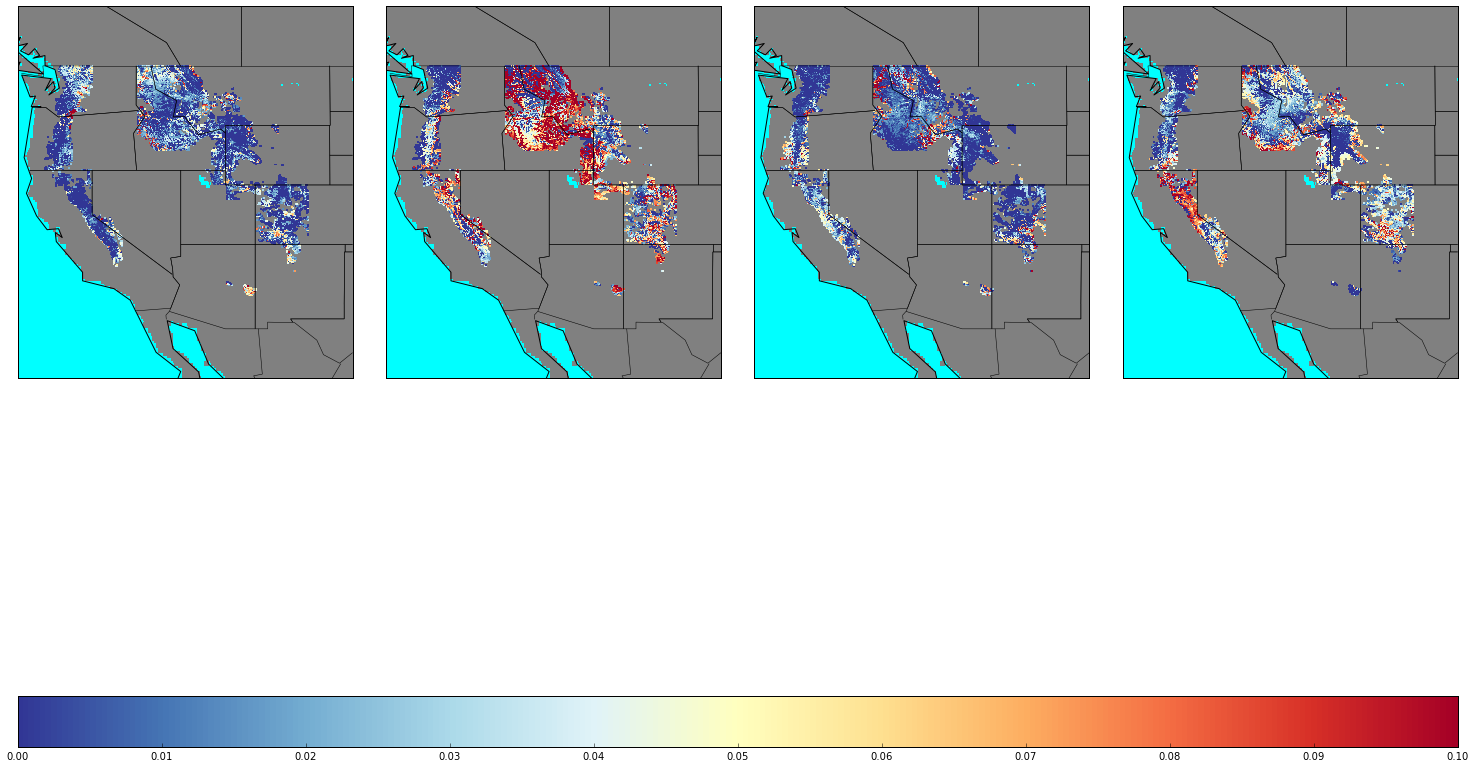

In [16]:
from pylab import *
lt = 20
rt = 14
fig = plt.figure(figsize=(lt,rt))
basins = ['cascades','california','northernrockies','southernrockies','whites']
# scenarios = ['historical','rcp45','rcp45','rcp45','historical','rcp85','rcp85','rcp85']
scenarios = ['historical','rcp45','rcp45','rcp45']
chunks = ['1970-1999','2010-2039','2040-2069','2070-2099']
# chunks = ['1970-1999','2010-2039','2040-2069','2070-2099','1970-1999','2010-2039','2040-2069','2070-2099']
for num in np.arange(len(chunks)):
    ax = fig.add_subplot(1,4,num+1)
    #ax = fig.add_subplot(2,4,num+1)
    m = make_map()
    for basin in basins: 
        ## get data 
        direc = '/raid9/gergel/agg_snowpack/%s/' %scenarios[num]
        filename = "moistdef_%s_%s.npz" %(chunks[num],basin)
        data = np.load(os.path.join(direc,filename))
        lats_inc = data['lats']
        lons_inc = data['lons']
        pet = data['pet'][:,:,0] # (#lats,)
        aet = data['aet'][:,0,:,0] # (#lats,)
        coms = data['coms'] ## centers of mass (#lats,30)
        # var_series = np.divide(aet,pet)
        # var_series = np.subtract(pet,aet)
        var_series = early_vs_late_moist_deficit(pet,aet,coms)
        lons_mesh,lats_mesh,data_mesh = mesh_gridify(lats_inc.reshape(len(lats_inc),1),lons_inc.reshape(len(lats_inc),1),var_series.reshape(len(lats_inc),1)) 
        cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu_r',latlon=True,zorder=1,vmin=0,vmax=0.10)
        # cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu',latlon=True,zorder=1,vmin=800,vmax=2500)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0.1,hspace=0.00000001,wspace=0.1)
cax = fig.add_axes([0.0, 0.0, 1.0, 0.05])
colorbar(cax=cax,orientation='horizontal')
## save figure
direc = '/raid9/gergel/agg_snowpack/fire_risk/plots'
plotname = 'fire_risk' 
savepath = os.path.join(direc,plotname)
print("saving figure to %s" %savepath)
plt.savefig(savepath)

1970-1999
[ 51.6         42.93333333  84.36666667 ...,  90.9         87.23333333
  87.06666667]
[ 47.96666667  53.26666667  36.96666667 ...,  46.66666667  49.93333333
  49.5       ]
[ 63.56666667  88.16666667  87.16666667 ...,  85.63333333  73.36666667
  61.16666667]
[ 44.6         47.63333333  46.76666667 ...,  46.33333333  55.33333333
  53.06666667]
[ 47.33333333  55.73333333  58.3         49.76666667  41.2         39.43333333
  41.8         51.06666667  58.56666667  56.36666667  44.83333333
  45.53333333  45.06666667  42.63333333  39.13333333  43.          43.26666667
  42.73333333  40.7         44.76666667  45.66666667  50.86666667
  50.16666667  45.03333333  41.06666667  41.46666667  47.03333333
  42.56666667  43.1         49.96666667  55.3         59.53333333
  56.96666667  54.86666667  53.33333333  48.76666667  44.96666667
  50.86666667  45.66666667  38.73333333  45.8         51.13333333  60.4
  68.73333333  67.36666667  56.5         52.          49.36666667
  49.33333333  49.53

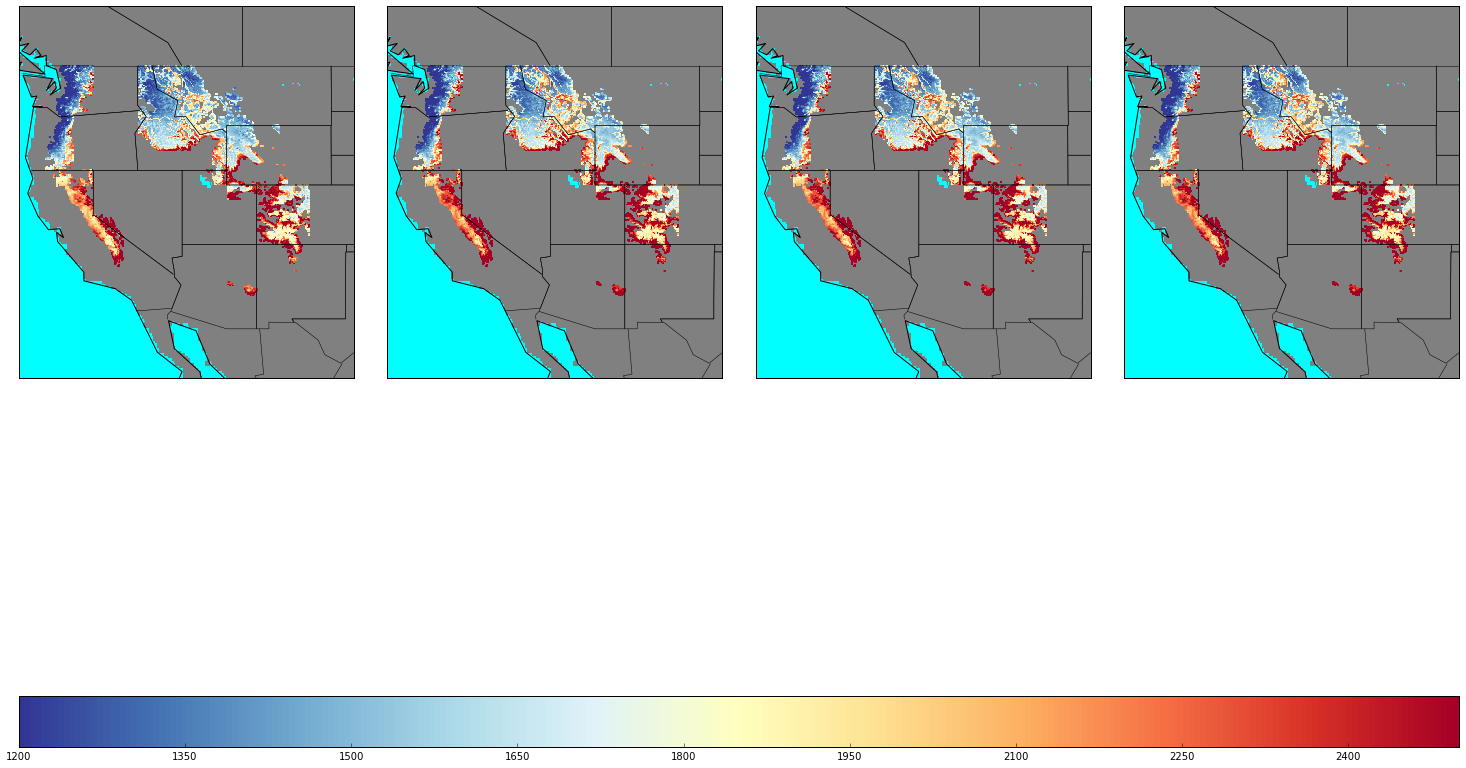

In [27]:
from pylab import *
lt = 20
rt = 14
fig = plt.figure(figsize=(lt,rt))
basins = ['cascades','california','northernrockies','southernrockies','whites']
# scenarios = ['historical','rcp45','rcp45','rcp45','historical','rcp85','rcp85','rcp85']
scenarios = ['historical','rcp45','rcp45','rcp45']
chunks = ['1970-1999','2010-2039','2040-2069','2070-2099']
# chunks = ['1970-1999','2010-2039','2040-2069','2070-2099','1970-1999','2010-2039','2040-2069','2070-2099']
for num in np.arange(len(chunks)):
    ax = fig.add_subplot(1,4,num+1)
    #ax = fig.add_subplot(2,4,num+1)
    m = make_map()
    print(chunks[num])
    for basin in basins: 
        ## get data 
        direc = '/raid9/gergel/agg_snowpack/%s/' %scenarios[num]
        filename = "moistdef_%s_%s.npz" %(chunks[num],basin)
        data = np.load(os.path.join(direc,filename))
        lats_inc = data['lats']
        lons_inc = data['lons']
        pet = data['pet'][:,:,0] # (#lats,)
        aet = data['aet'][:,0,:,0] # (#lats,)
        coms = data['coms'] ## centers of mass (#lats,30)
        # var_series = np.divide(aet,pet)
        var_series = np.mean(pet,axis=1) - np.mean(aet,axis=1)
        # print(np.nanmean(var_series))
        # print(np.mean(coms,axis=1))
        #var_series = early_vs_late_moist_deficit(pet,aet,coms)
        lons_mesh,lats_mesh,data_mesh = mesh_gridify(lats_inc.reshape(len(lats_inc),1),lons_inc.reshape(len(lats_inc),1),var_series.reshape(len(lats_inc),1)) 
        cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu_r',latlon=True,zorder=1,vmin=1200,vmax=2500)
        # cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu',latlon=True,zorder=1,vmin=800,vmax=2500)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0.1,hspace=0.00000001,wspace=0.1)
cax = fig.add_axes([0.0, 0.0, 1.0, 0.05])
colorbar(cax=cax,orientation='horizontal')
## save figure
direc = '/raid9/gergel/agg_snowpack/fire_risk/plots'
plotname = 'fire_risk' 
savepath = os.path.join(direc,plotname)
print("saving figure to %s" %savepath)
plt.savefig(savepath)